<a href="https://colab.research.google.com/github/AgainstEntropy/ECE-GY-6143-ML/blob/main/2_advertising_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name: Yihao Wang**

**NetID: yw7486**

Assignment: Linear regression on the Advertising data
=====================================================

*Fraida Fund*

Submit answers to the questions in PrairieLearn as you work through this notebook.

To illustrate principles of linear regression, we are going to use some data from the textbook “An Introduction to Statistical Learning withApplications in R” (Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani) (available via NYU Library).

The dataset is described as follows:

> Suppose that we are statistical consultants hired by a client to provide advice on how to improve sales of a particular product. The `Advertising` data set consists of the sales of that product in 200 different markets, along with advertising budgets for the product in each of those markets for three different media: TV, radio, and newspaper.
>
> …
>
> It is not possible for our client to directly increase sales of the product. On the other hand, they can control the advertising expenditure in each of the three media. Therefore, if we determine that there is an association between advertising and sales, then we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales. In other words, our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

Sales are reported in thousands of units, and TV, radio, and newspaper budgets, are reported in thousands of dollars.

For this assignment, you will fit a linear regression model to a small dataset. You will iteratively improve your linear regression model by examining the residuals at each stage, in order to identify problems with the model.

Make sure to include your name and net ID in a text cell at the top of the notebook.

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 0. Read in and pre-process data

In this section, you will read in the “Advertising” data, and make sure it is loaded correctly. Visually inspect the data using a pairplot, and note any meaningful observations. In particular, comment on which features appear to be correlated with product sales, and which features appear to be correlated with one another. Then, split the data into training data (70%) and test data (30%).

**The code in this section is provided for you**.

#### Read in data

In [ ]:
!wget 'https://www.statlearning.com/s/Advertising.csv' -O 'Advertising.csv'

--2023-09-27 15:45:09--  https://www.statlearning.com/s/Advertising.csv
Resolving www.statlearning.com (www.statlearning.com)... 198.185.159.144, 198.49.23.145, 198.185.159.145, ...
Connecting to www.statlearning.com (www.statlearning.com)|198.185.159.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/5fffe03b4091076ff5b30c72/1610604603901/Advertising.csv [following]
--2023-09-27 15:45:09--  https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/5fffe03b4091076ff5b30c72/1610604603901/Advertising.csv
Resolving static1.squarespace.com (static1.squarespace.com)... 151.101.0.238, 151.101.64.238, 151.101.128.238, ...
Connecting to static1.squarespace.com (static1.squarespace.com)|151.101.0.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4555 (4.4K) [text/csv]
Saving to: ‘Advertising.csv’

Advertising.csv     100%[===================>]   4.45K  --.-KB/s  

In [ ]:
df  = pd.read_csv('Advertising.csv', index_col=0)
# df  = pd.read_csv('Advertising.csv')
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Note that in this dataset, the first column in the data file is the row label; that’s why we use `index_col=0` in the `read_csv` command. If we would omit that argument, then we would have an additional (unnamed) column in the dataset, containing the row number.

(You can try removing the `index_col` argument and re-running the cell above, to see the effect and to understand why we used this argument.)

#### Visually inspect the data

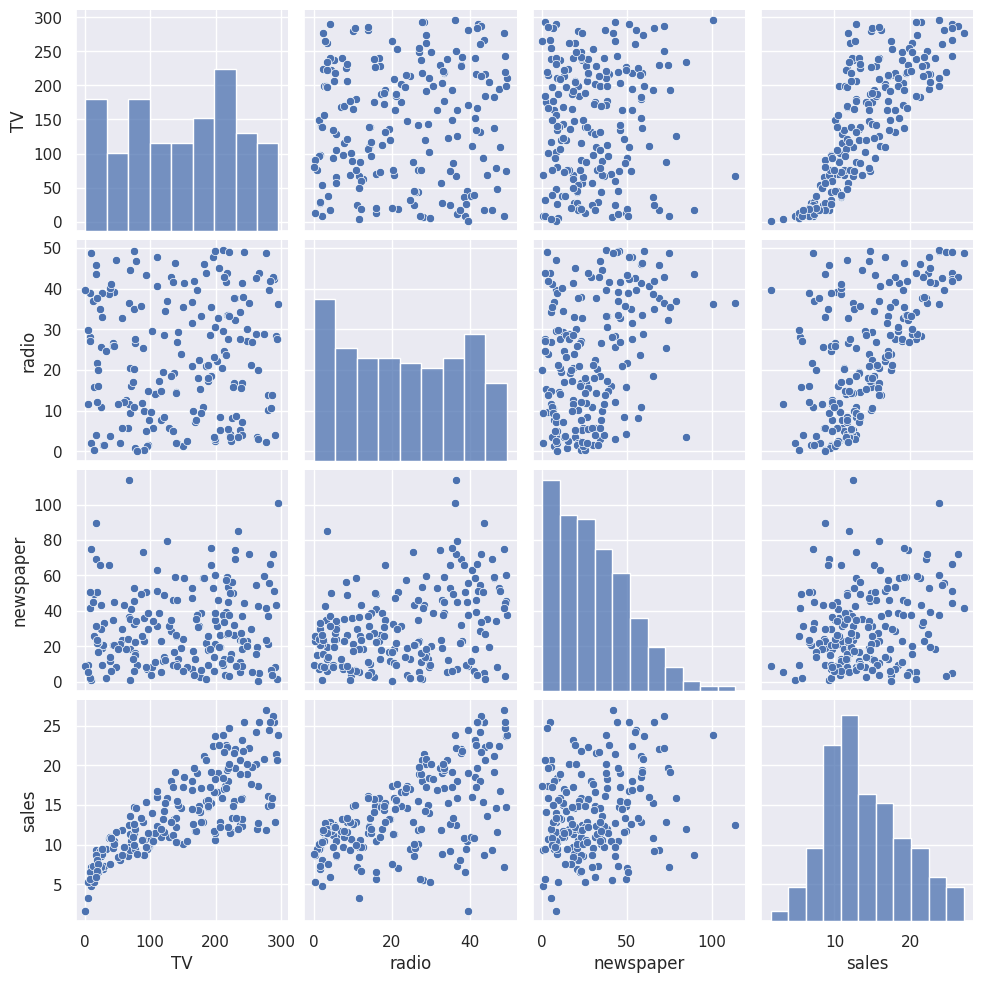

In [ ]:
sns.pairplot(df);

The most important panels here are on the bottom row, where `sales` is on the vertical axis and the advertising budgets are on the horizontal axes.

Looking at this row, it appears that TV ad spending and radio ad spending are likely to be useful predictive features for `sales`; for newspaper ad spending, it is not clear from the pairplot whether there is a relationship.

#### Split up data

We will use 70% of the data for training and the remaining 30% to evaluate the regression model on data *not* used for training.

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=9)

We will set the `random_state` to a constant so that every time you run this notebook, exactly the same data points will be assigned to test vs. training sets. This is helpful in the debugging stage.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 134 to 127
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         140 non-null    float64
 1   radio      140 non-null    float64
 2   newspaper  140 non-null    float64
 3   sales      140 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 85 to 7
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         60 non-null     float64
 1   radio      60 non-null     float64
 2   newspaper  60 non-null     float64
 3   sales      60 non-null     float64
dtypes: float64(4)
memory usage: 2.3 KB


In [ ]:
train[['TV', 'radio', 'newspaper']].corr()

,TV,radio,newspaper
TV,1.000000,0.106568,0.057997
radio,0.106568,1.000000,0.314422
newspaper,0.057997,0.314422,1.000000


### 1. Fit simple linear regression models

Use the training data to fit a simple linear regression to predict product sales, for each of three features: TV ad budget, radio ad budget, and newspaper ad budget. In other words, you will fit *three* regression models, with each model being trained on one feature. For each of the three regression models, create a plot of the training data and the regression line, with product sales ($y$) on the vertical axis and the feature on which the model was trained ($x$) on the horizontal axis.

Also, for each regression model, print the intercept and coefficients, and compute the MSE and R2 on the training data, and MSE and R2 on the test data.

Comment on the results. Which type of ad spending seems to be associated with the largest increase in product sales? Which regression model is most effective at predicting product sales?

*The Radio seems to be associated with the largest increase in sales.And the TV model is most effective at predicting sales*

**The code in this section is provided for you**. However, you will need to add comments, observations, and answers to the questions.

#### Fit a simple linear regression

In [ ]:
reg_tv    = LinearRegression().fit(train[['TV']], train['sales'])
reg_radio = LinearRegression().fit(train[['radio']], train['sales'])
reg_news  = LinearRegression().fit(train[['newspaper']], train['sales'])

#### Look at coefficients

In [ ]:
print("TV       : ", reg_tv.coef_[0], reg_tv.intercept_)
print("Radio    : ", reg_radio.coef_[0], reg_radio.intercept_)
print("Newspaper: ", reg_news.coef_[0], reg_news.intercept_)

TV       :  0.04964468781898984 6.711432632336138
Radio    :  0.21062312839115208 8.997640913704718
Newspaper:  0.046574464282301664 12.375549417451523


#### Plot data and regression line

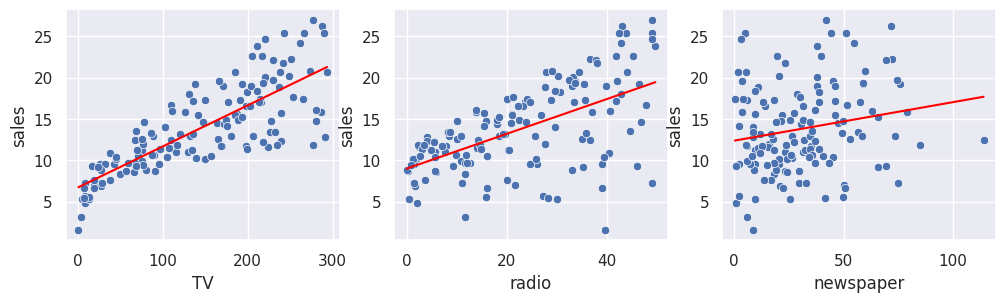

In [ ]:
fig = plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
sns.scatterplot(data=train, x="TV", y="sales");
sns.lineplot(data=train, x="TV", y=reg_tv.predict(train[['TV']]), color='red');

plt.subplot(1,3,2)
sns.scatterplot(data=train, x="radio", y="sales");
sns.lineplot(data=train, x="radio", y=reg_radio.predict(train[['radio']]), color='red');

plt.subplot(1,3,3)
sns.scatterplot(data=train, x="newspaper", y="sales");
sns.lineplot(data=train, x="newspaper", y=reg_news.predict(train[['newspaper']]), color='red');

#### Compute R2, MSE for simple regression

In [ ]:
y_pred_tr_tv    = reg_tv.predict(train[['TV']])
y_pred_tr_radio = reg_radio.predict(train[['radio']])
y_pred_tr_news  = reg_news.predict(train[['newspaper']])

In [ ]:
r2_tr_tv    = metrics.r2_score(train['sales'], y_pred_tr_tv)
r2_tr_radio = metrics.r2_score(train['sales'], y_pred_tr_radio)
r2_tr_news  = metrics.r2_score(train['sales'], y_pred_tr_news)
print("TV       : ", r2_tr_tv)
print("Radio    : ", r2_tr_radio)
print("Newspaper: ", r2_tr_news)

TV       :  0.6462575775839753
Radio    :  0.33630082549935214
Newspaper:  0.0373981756207491


In [ ]:
mse_tr_tv    = metrics.mean_squared_error(train['sales'], y_pred_tr_tv)
mse_tr_radio = metrics.mean_squared_error(train['sales'], y_pred_tr_radio)
mse_tr_news  = metrics.mean_squared_error(train['sales'], y_pred_tr_news)
print("TV       : ", mse_tr_tv)
print("Radio    : ", mse_tr_radio)
print("Newspaper: ", mse_tr_news)

TV       :  9.798510609335318
Radio    :  18.384177273212142
Newspaper:  26.663650133692155


In [ ]:
y_pred_ts_tv    = reg_tv.predict(test[['TV']])
y_pred_ts_radio = reg_radio.predict(test[['radio']])
y_pred_ts_news  = reg_news.predict(test[['newspaper']])

In [ ]:
r2_ts_tv    = metrics.r2_score(test['sales'], y_pred_ts_tv)
r2_ts_radio = metrics.r2_score(test['sales'], y_pred_ts_radio)
r2_ts_news  = metrics.r2_score(test['sales'], y_pred_ts_news)
print("TV       : ", r2_ts_tv)
print("Radio    : ", r2_ts_radio)
print("Newspaper: ", r2_ts_news)

TV       :  0.5138892470208256
Radio    :  0.3072356147167632
Newspaper:  0.06497948830922318


In [ ]:
mse_ts_tv    = metrics.mean_squared_error(test['sales'], y_pred_ts_tv)
mse_ts_radio = metrics.mean_squared_error(test['sales'], y_pred_ts_radio)
mse_ts_news  = metrics.mean_squared_error(test['sales'], y_pred_ts_news)
print("TV       : ", mse_ts_tv)
print("Radio    : ", mse_ts_radio)
print("Newspaper: ", mse_ts_news)

TV       :  12.288041294264643
Radio    :  17.511888641395615
Newspaper:  23.635705625160178


### 2. Explore the residuals for the single linear regression models

We know that computing MSE or R2 is not sufficient to diagnose a problem with a linear regression.

Create some additional plots as described below to help you identify any problems with the regression. Use training data for all of the items below.

For each of the three regression models, you will compute the residuals ($y - \hat{y}$). Then, you’ll create three plots - each with three subplots, one for each regression model - as follows:

**Plot 1**: Create a scatter plot of predicted sales ($\hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis. Make sure both axes use the same scale (the range of the vertical axis should be the same as the range of the horizontal axis) *and* that all three subplots use the same scale. Label each axes, and each plot. What would you expect this plot to look like for a model that explains the data well?

*I expect three diagnal lines*

**Plot 2**: Create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis. Use the same scale for all three subplots. Comment on your observations. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to actual sales?

*There are patterns in all three subplots. What's more, the linear property in the third plot is the best among three models, which might indicates that the news feature is the weakest(most irrelated) feature to explain the data.*

**Plot 3**: For each of the three regression models AND each of the three features, create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and the feature ($x$) on the horizontal axis. This plot will include nine subplots in total, for every combination of regression model and feature. Make sure to clearly label each axis, and also label each subplot with a title that indicates which regression model it uses. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to each of the three features?

*There is a somekind strong residual pattern in the subplots of TV-TV, TV-radio, radio-radio, news-TV, news-radio, which indicates that only single linear regression can not explain the data well. We need multiple linear regression model to combine all features.*

**The code in this section is not provided for you**. You will need to write code, as well as comments, observations, and answers to the questions.

------------------------------------------------------------------------

Note that in general, to earn full credit, plots must:

-   Be readable (especially text size).
-   Have a label on each axis.
-   Have an appropriate range for each axis. When there are multiple subplots, if the goal is to compare similar things in different subplots, in most cases it is appropriate for them all to use the same range.
-   If there are multiple subplots, or multiple data series in the same plot, it must be made clear which is which.

#### Plot 1: predicted values $\hat{y}$ vs. true values $y$

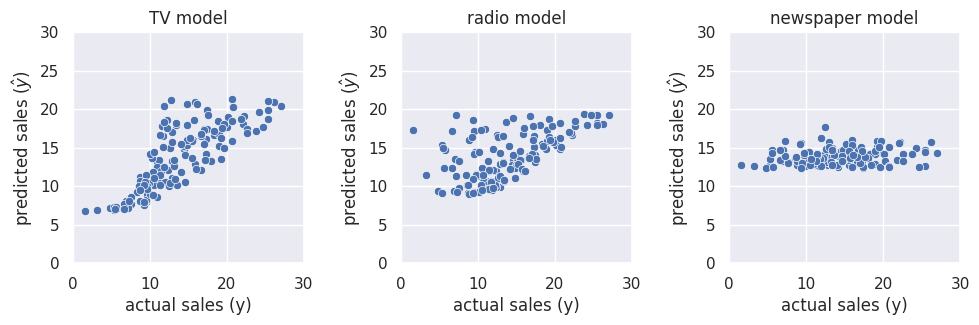

In [ ]:
# lim_low = np.min(train["sales"])
# lim_high = np.max(train["sales"])
lim_low = np.min(0)
lim_high = np.max(30)

fig = plt.figure(figsize=(12,3))

for idx, (feat, pred) in enumerate(
    zip(['TV', 'radio', 'newspaper'],
        [y_pred_tr_tv, y_pred_tr_radio, y_pred_tr_news])):
    ax = fig.add_subplot(1, 3, idx+1)
    ax = sns.scatterplot(x=train["sales"], y=pred)
    _ = ax.set_xlim(lim_low, lim_high)
    _ = ax.set_ylim(lim_low, lim_high)
    _ = ax.set_aspect(1)
    _ = ax.set_xlabel('actual sales (y)')
    _ = ax.set_ylabel('predicted sales ($\hat{y}$)')
    _ = ax.set_title(f'{feat} model')

#### Plot 2: residual values $y-\hat{y}$ vs. true values $y$

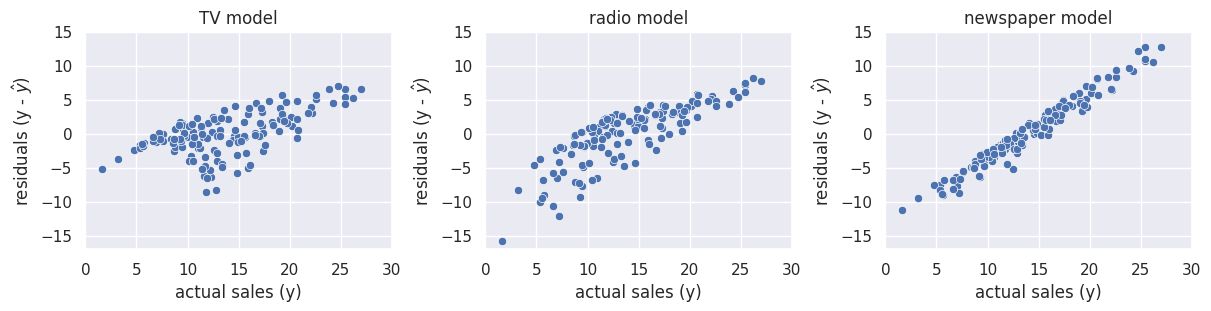

In [ ]:
x_lim_low = np.min(0)
x_lim_high = np.max(30)
y_lim_low = -17
y_lim_high = 15

fig = plt.figure(figsize=(12, 3), constrained_layout=True)

for idx, (feat, pred) in enumerate(
    zip(['TV', 'radio', 'newspaper'],
        [y_pred_tr_tv, y_pred_tr_radio, y_pred_tr_news])):
    ax = fig.add_subplot(1, 3, idx+1)
    ax = sns.scatterplot(x=train["sales"], y=train["sales"] - pred)
    _ = ax.set_xlim(x_lim_low, x_lim_high)
    _ = ax.set_ylim(y_lim_low, y_lim_high)
    _ = ax.set_xlabel('actual sales (y)')
    _ = ax.set_ylabel('residuals (y - $\hat{y}$)')
    _ = ax.set_title(f'{feat} model')

fig.show()

#### Plot 3: residual values $y-\hat{y}$ vs. true values $y$

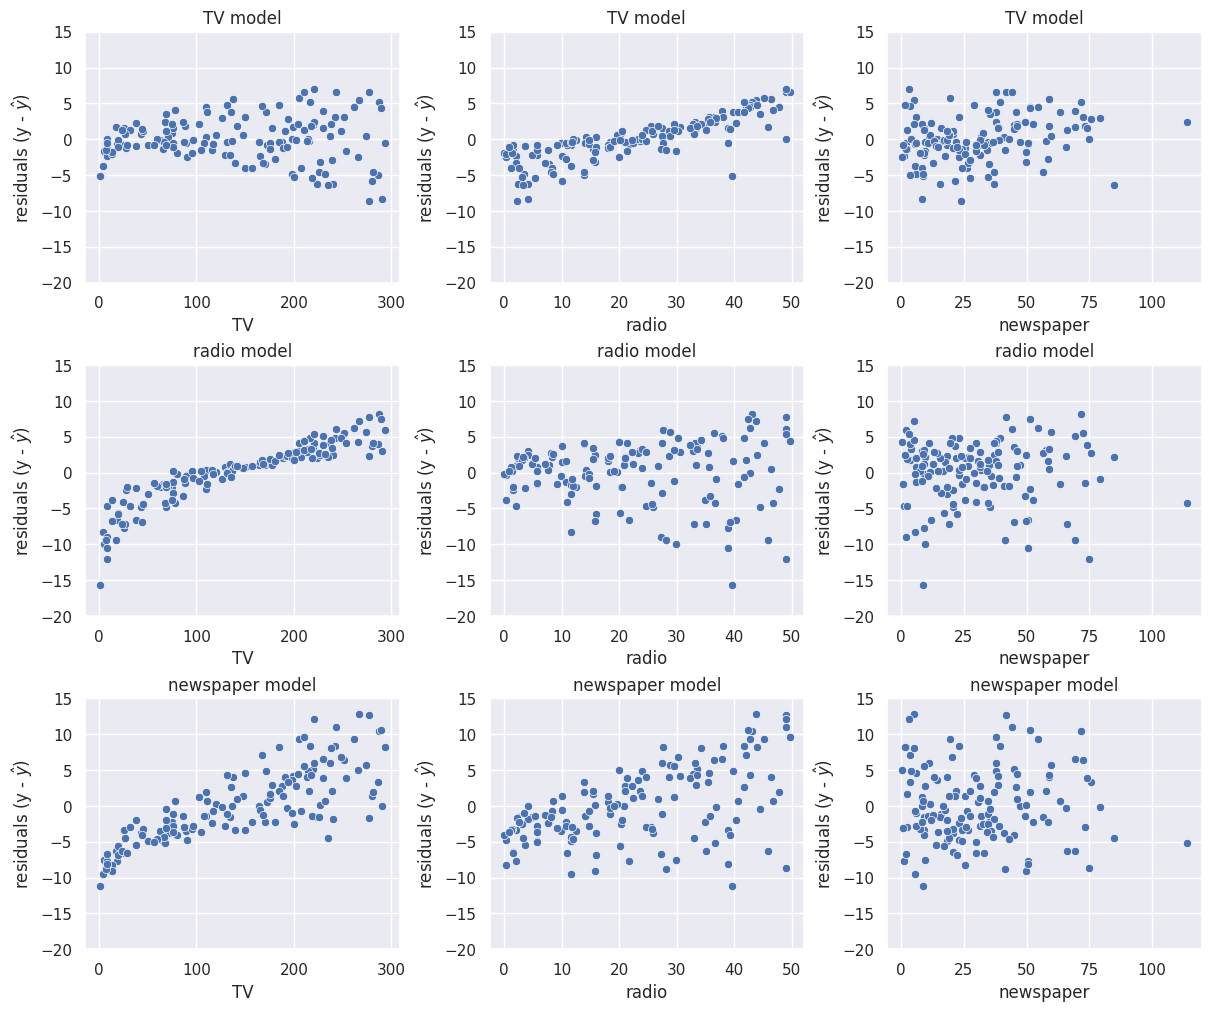

In [ ]:
y_lim_low = -20
y_lim_high = 15

fig = plt.figure(figsize=(12, 10), constrained_layout=True)
subplot_idx = 0

for idx, (feat_y, pred) in enumerate(
    zip(['TV', 'radio', 'newspaper'],
        [y_pred_tr_tv, y_pred_tr_radio, y_pred_tr_news])):
    for feat_x in ['TV', 'radio', 'newspaper']:
        subplot_idx += 1
        ax = fig.add_subplot(3, 3, subplot_idx)
        ax = sns.scatterplot(x=train[feat_x], y=train["sales"] - pred)
        _ = ax.set_ylim(y_lim_low, y_lim_high)
        _ = ax.set_xlabel(feat_x)
        _ = ax.set_ylabel('residuals (y - $\hat{y}$)')
        _ = ax.set_title(f'{feat_y} model')

fig.show()

Text(0.5, 1.0, 'Model based on: TV, Feature: TV')

Text(0.5, 0, 'TV Value')

Text(0, 0.5, 'Residuals')

(-20.0, 20.0)

ValueError: ignored

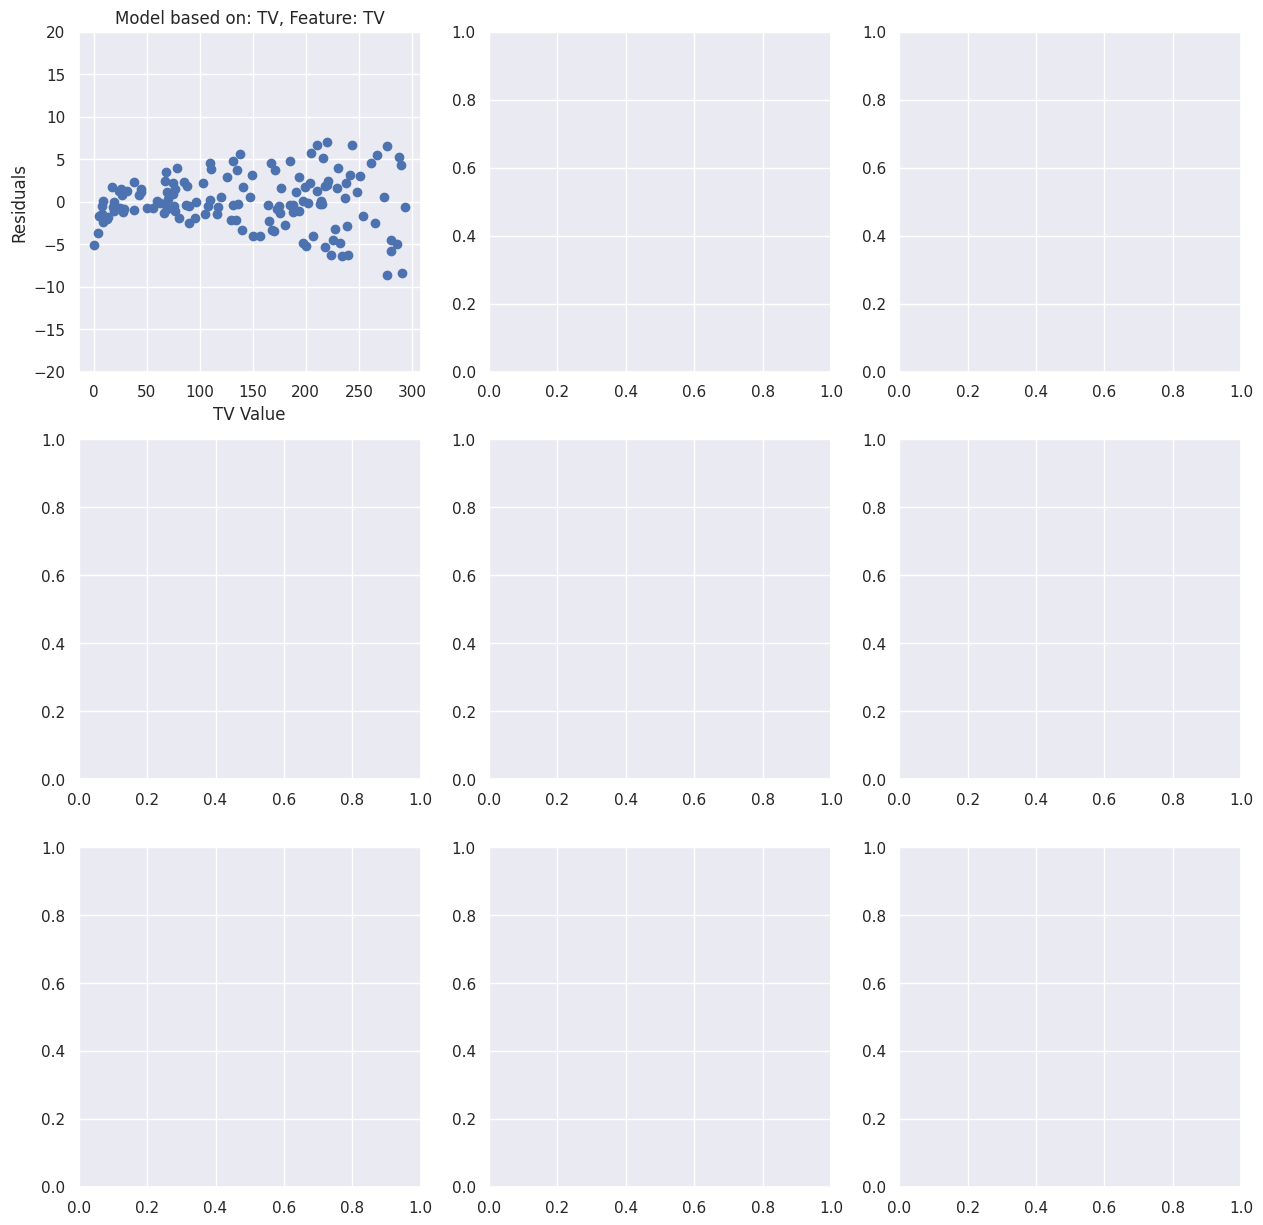

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
features = ['TV', 'radio', 'newspaper']


models = {feature: LinearRegression().fit(train[[feature]], train['sales']) for feature in features}

for i, model_feature in enumerate(features):
    for j, plot_feature in enumerate(features):

        residuals = train['sales'] - models[model_feature].predict(train[[plot_feature]])
        # residuals = train['sales'] - models[model_feature].predict(train[[model_feature]])

        axs[i, j].scatter(train[plot_feature], residuals)
        axs[i, j].set_title(f'Model based on: {model_feature}, Feature: {plot_feature}')
        axs[i, j].set_xlabel(f'{plot_feature} Value')
        axs[i, j].set_ylabel('Residuals')
        axs[i, j].set_ylim(-20, 20)

plt.tight_layout()
plt.show()

### 3. Try a multiple linear regression

Next, fit a multiple linear regression to predict product sales, using all three features to train a single model: TV ad budget, radio ad budget, and newspaper ad budget.

Print the intercept and coefficients, and compute the MSE and R2 on the training data, and MSE and R2 on the test data. Comment on the results. Make sure to explain any differences between the coefficients of the multiple regression model, and the coefficients of the three simple linear regression models. If they are different, why?

**The code in the first part of this section is provided for you**. However, you will need to add comments, observations, and answers to the questions.

Also repeat the analysis of part (3) for this regression model. Use training data for all of these items:

**Plot 1**: Create a scatter plot of predicted sales ($\hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis. Make sure both axes use the same scale (the range of the vertical axis should be the same as the range of the horizontal axis). Label each axes. Does this model explain the data more effectively than the simple linear regressions from the previous section?

*I think the muliple linear refgression model does a better job on explaining the data because all data points fall near the diagnol line, and this model has the largest $R^2$ and the smallest MSE error.*

**Plot 2**: Create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis. Comment on your observations. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to actual sales?

*There is a pattern with poor regularity in the residuals, which might indicates that we need to append more complicated features to better fit the data.*

**Plot 3**: For each of the three features, plot the residuals ($y - \hat{y}$) on the vertical axis, and the feature ($x$) on the horizontal axis. Make sure to clearly label each axis. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to each of the three features?

*There are patterns in all three subplots, and the patterns in the first two subplots are slightly stronger than that in the third subplot. These patterns indiacate that we need to pay more attention to complicated features related to TV and radio.*

------------------------------------------------------------------------

Note that in general, to earn full credit, plots must:

-   Be readable (especially text size).
-   Have a label on each axis.
-   Have an appropriate range for each axis. When there are multiple subplots, if the goal is to compare similar things in different subplots, in most cases it is appropriate for them all to use the same range.
-   If there are multiple subplots, or multiple data series in the same plot, it must be made clear which is which.

#### Fit a multiple linear regression

In [ ]:
reg_multi = LinearRegression().fit(train[['TV', 'radio', 'newspaper']], train['sales'])

#### Look at coefficients

In [ ]:
print("Coefficients (TV, radio, newspaper):", reg_multi.coef_)
print("Intercept: ", reg_multi.intercept_)

Coefficients (TV, radio, newspaper): [ 0.04636712  0.18249225 -0.00196151]
Intercept:  3.0762941463550604


#### Compute R2, MSE for multiple regression

In [ ]:
y_pred_tr_multi = reg_multi.predict(train[['TV', 'radio', 'newspaper']])

r2_tr_multi  = metrics.r2_score(train['sales'], y_pred_tr_multi)
mse_tr_multi = metrics.mean_squared_error(train['sales'], y_pred_tr_multi)

print("Multiple regression R2:  ", r2_tr_multi)
print("Multiple regression MSE: ", mse_tr_multi)


Multiple regression R2:   0.8934006397815405
Multiple regression MSE:  2.952755722412376


In [ ]:
y_pred_ts_multi = reg_multi.predict(test[['TV', 'radio', 'newspaper']])

r2_ts_multi  = metrics.r2_score(test['sales'], y_pred_ts_multi)
mse_ts_multi = metrics.mean_squared_error(test['sales'], y_pred_ts_multi)

print("Multiple regression R2:  ", r2_ts_multi)
print("Multiple regression MSE: ", mse_ts_multi)


Multiple regression R2:   0.9034495005656622
Multiple regression MSE:  2.4406300760885373


### Explore the residuals for the multiple linear regression models

#### Plot 1

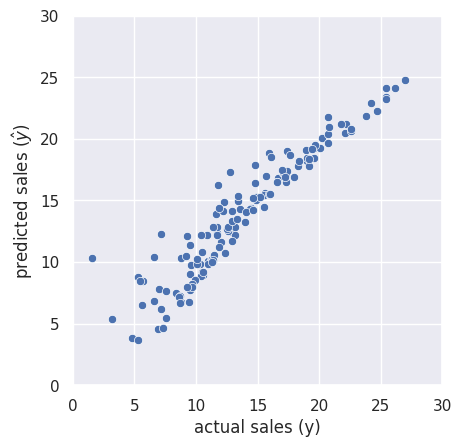

In [ ]:
lim_low = np.min(0)
lim_high = np.max(30)

fig, ax = plt.subplots()
ax = sns.scatterplot(x=train["sales"], y=y_pred_tr_multi)
_ = ax.set_xlim(lim_low, lim_high)
_ = ax.set_ylim(lim_low, lim_high)
_ = ax.set_aspect(1)
_ = ax.set_xlabel('actual sales (y)')
_ = ax.set_ylabel('predicted sales ($\hat{y}$)')

#### Plot 2

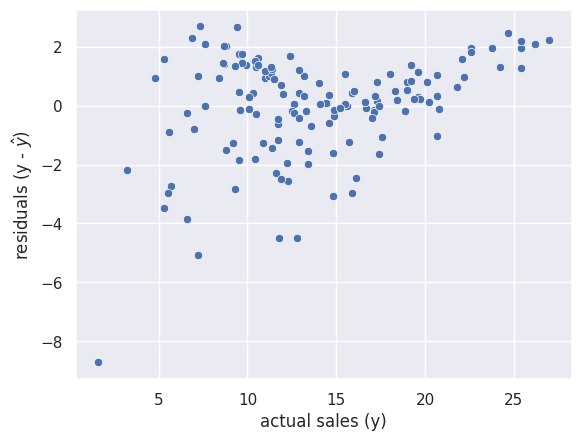

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=train["sales"], y=train["sales"] - y_pred_tr_multi)
_ = ax.set_xlabel('actual sales (y)')
_ = ax.set_ylabel('residuals (y - $\hat{y}$)')

#### Plot 3

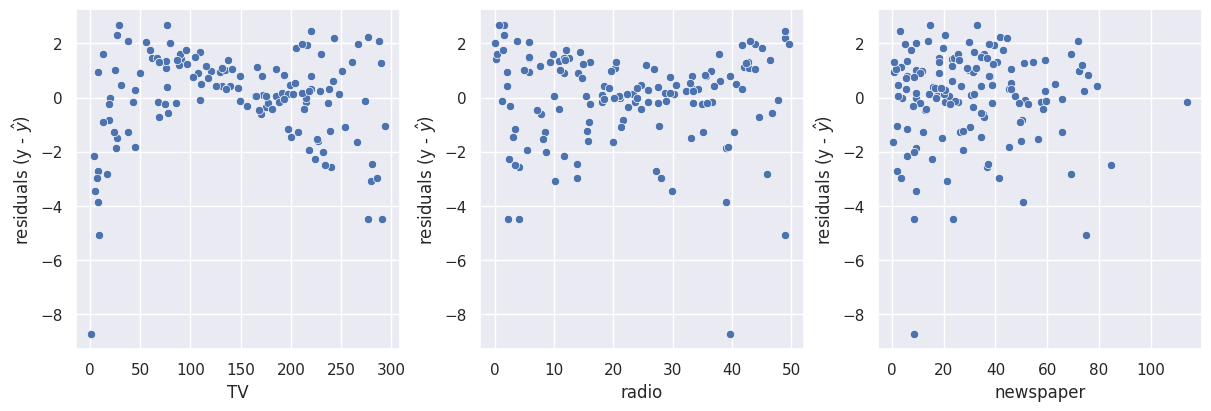

In [ ]:
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
subplot_idx = 0

for idx, feat_x in enumerate(['TV', 'radio', 'newspaper']):
    ax = fig.add_subplot(1, 3, idx+1)
    ax = sns.scatterplot(x=train[feat_x], y=train["sales"] - y_pred_tr_multi)
    _ = ax.set_xlabel(feat_x)
    _ = ax.set_ylabel('residuals (y - $\hat{y}$)')

### 4. Linear regression with interaction terms

Our multiple linear regression includes additive effects of all three types of advertising media. However, it does not include *interaction* effects, in which combining different types of advertising media together results in a bigger boost in sales than just the additive effect of the individual media.

The pattern in the residuals plots from parts (1) through (3) suggest that a model including an interaction effect may explain sales data better than a model including additive effects. Add four columns to each data frame (`train` and `test`):

-   `newspaper` $\times$ `radio` (name this column `newspaper_radio`)
-   `TV` $\times$ `radio` (name this column `TV_radio`)
-   `newspaper` $\times$ `TV` (name this column `newspaper_TV`)
-   `newspaper` $\times$ `radio` $\times$ `TV` (name this column `newspaper_radio_TV`)

Note: you can use the `assign` function in `pandas` ([documentation here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html)) to create a new column and assign a value to it using operations on other columns.

Then, train a linear regression model on all seven features: the three types of ad budgets, and the four interaction effects. Repeat the analysis of part (3) for the model including interaction effects. Are the interaction effects helpful for explaining the effect of ads on product sales? Are there any patterns evident in the residual plots that suggest further opportunities for improving the model?

*The interactions do provide better explaination to the data. The residual-TV subplot indicates a remaining non-linear pattern for furthur improving.*

**The code in this section is not provided for you**. You will need to write code, in addition to comments, observations, and answers to the questions.

------------------------------------------------------------------------

Note that in general, to earn full credit, plots must:

-   Be readable (especially text size).
-   Have a label on each axis.
-   Have an appropriate range for each axis. When there are multiple subplots, if the goal is to compare similar things in different subplots, in most cases it is appropriate for them all to use the same range.
-   If there are multiple subplots, or multiple data series in the same plot, it must be made clear which is which.

In [ ]:
train = train.assign(newspaper_radio = train['newspaper'] * train['radio'])
train = train.assign(TV_radio = train['TV'] * train['radio'])
train = train.assign(newspaper_TV = train['newspaper'] * train['TV'])
train = train.assign(newspaper_radio_TV = train['newspaper'] * train['radio'] * train['TV'])

test = test.assign(newspaper_radio = test['newspaper'] * test['radio'])
test = test.assign(TV_radio = test['TV'] * test['radio'])
test = test.assign(newspaper_TV = test['newspaper'] * test['TV'])
test = test.assign(newspaper_radio_TV = test['newspaper'] * test['radio'] * test['TV'])

In [ ]:
train.head()

,TV,radio,newspaper,sales,newspaper_radio,TV_radio,newspaper_TV,newspaper_radio_TV
134,219.8,33.5,45.1,19.6,1510.85,7363.30,9912.98,332084.830
137,25.6,39.0,9.3,9.5,362.70,998.40,238.08,9285.120
155,187.8,21.1,9.5,15.6,200.45,3962.58,1784.10,37644.510
178,170.2,7.8,35.2,11.7,274.56,1327.56,5991.04,46730.112
69,237.4,27.5,11.0,18.9,302.50,6528.50,2611.40,71813.500


In [ ]:
reg_multi_inter = LinearRegression().fit(
    X=train[['TV', 'radio', 'newspaper',
             'newspaper_radio', 'TV_radio', 'newspaper_TV', 'newspaper_radio_TV']],
    y=train['sales'])

In [ ]:
print("Coefficients:", reg_multi_inter.coef_)
print("Intercept: ", reg_multi_inter.intercept_)

Coefficients: [ 2.07581277e-02  1.19519832e-02  2.03755245e-02 -2.46384818e-05
  1.18859985e-03 -8.06743937e-05 -7.25626214e-07]
Intercept:  6.378007972477893


In [ ]:
y_pred_tr_multi_inter = reg_multi_inter.predict(
    train[['TV', 'radio', 'newspaper',
           'newspaper_radio', 'TV_radio', 'newspaper_TV', 'newspaper_radio_TV']])

r2_tr_multi_inter  = metrics.r2_score(train['sales'], y_pred_tr_multi_inter)
mse_tr_multi_inter = metrics.mean_squared_error(train['sales'], y_pred_tr_multi_inter)

print("Multiple regression R2:  ", r2_tr_multi_inter)
print("Multiple regression MSE: ", mse_tr_multi_inter)

Multiple regression R2:   0.9639737928022052
Multiple regression MSE:  0.997910205484344


In [ ]:
y_pred_ts_multi_inter = reg_multi_inter.predict(
    test[['TV', 'radio', 'newspaper',
           'newspaper_radio', 'TV_radio', 'newspaper_TV', 'newspaper_radio_TV']])

r2_ts_multi_inter  = metrics.r2_score(test['sales'], y_pred_ts_multi_inter)
mse_ts_multi_inter = metrics.mean_squared_error(test['sales'], y_pred_ts_multi_inter)

print("Multiple regression R2:  ", r2_ts_multi_inter)
print("Multiple regression MSE: ", mse_ts_multi_inter)

Multiple regression R2:   0.978290346306146
Multiple regression MSE:  0.5487825962280087


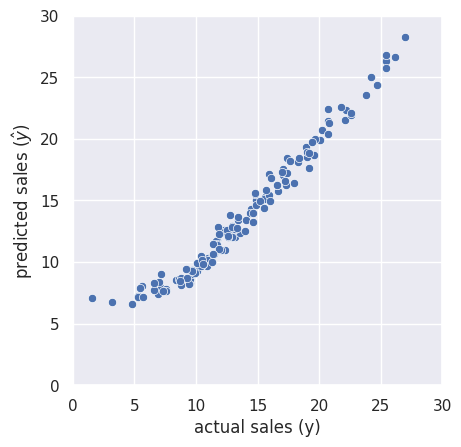

In [ ]:
lim_low = np.min(0)
lim_high = np.max(30)

fig, ax = plt.subplots()
ax = sns.scatterplot(x=train["sales"], y=y_pred_tr_multi_inter)
_ = ax.set_xlim(lim_low, lim_high)
_ = ax.set_ylim(lim_low, lim_high)
_ = ax.set_aspect(1)
_ = ax.set_xlabel('actual sales (y)')
_ = ax.set_ylabel('predicted sales ($\hat{y}$)')

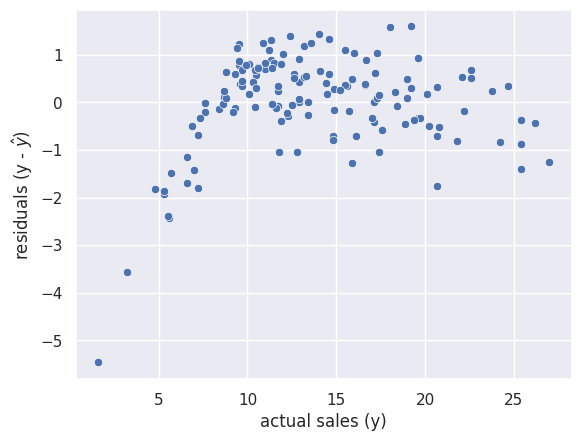

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=train["sales"], y=train["sales"] - y_pred_tr_multi_inter)
_ = ax.set_xlabel('actual sales (y)')
_ = ax.set_ylabel('residuals (y - $\hat{y}$)')

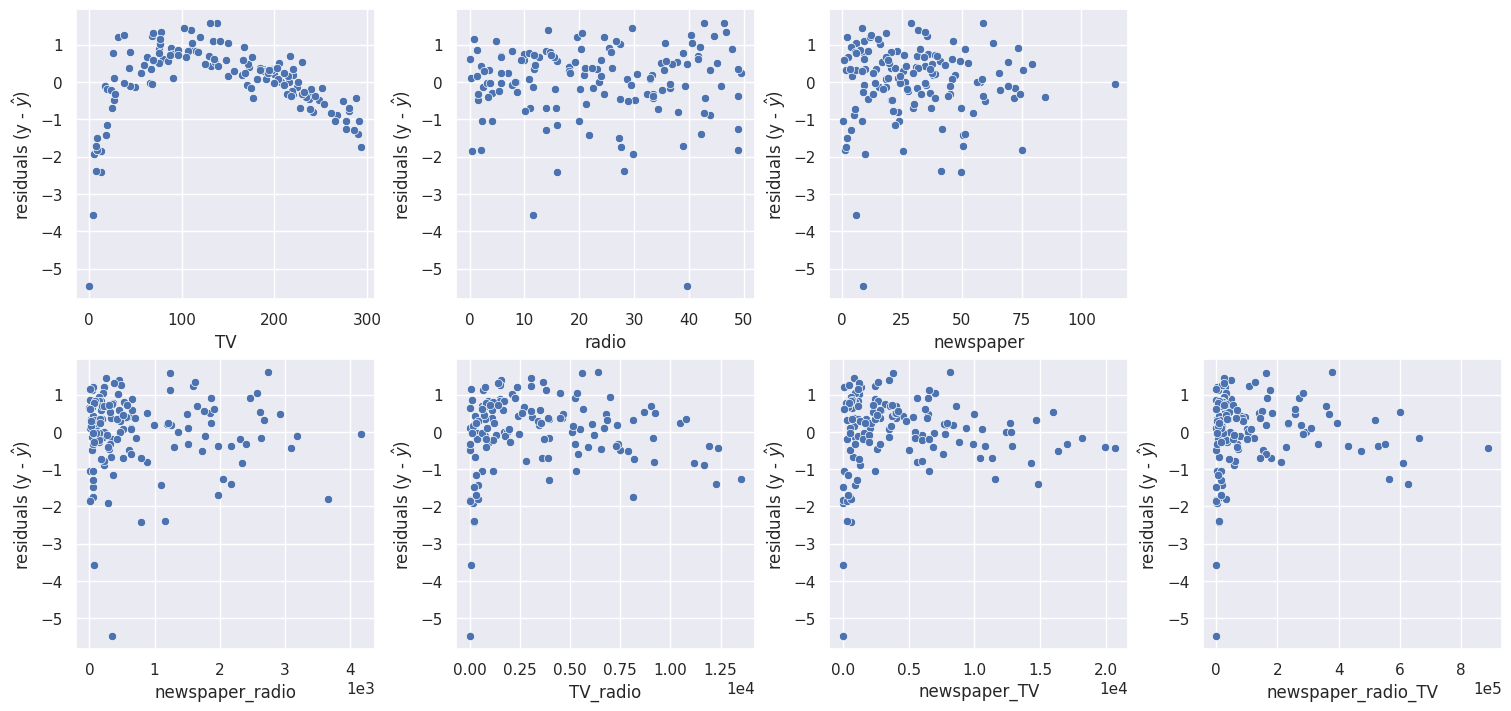

In [ ]:
features = ['TV', 'radio', 'newspaper',
            'newspaper_radio', 'TV_radio', 'newspaper_TV', 'newspaper_radio_TV']

fig = plt.figure(figsize=(15, 7), constrained_layout=True)

for idx, feat_x in enumerate(features[:3]):
    ax = fig.add_subplot(2, 4, idx+1)
    ax = sns.scatterplot(x=train[feat_x], y=train["sales"] - y_pred_tr_multi_inter)
    _ = ax.set_xlabel(feat_x)
    _ = ax.set_ylabel('residuals (y - $\hat{y}$)')

for idx, feat_x in enumerate(features[3:]):
    ax = fig.add_subplot(2, 4, idx+5)
    ax = sns.scatterplot(x=train[feat_x], y=train["sales"] - y_pred_tr_multi_inter)
    _ = ax.set_xlabel(feat_x)
    _ = ax.set_ylabel('residuals (y - $\hat{y}$)')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))